This post is inspired by the [blog](http://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html).

In this post, I will use the blog data to predict the age and genders of the bloggers. 

In [1]:
import tensorflow as tf
import pandas as pd
import blogs_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

Shuffling the data frame and resetting the index

In [2]:
df = blogs_data.loadBlogs().sample(frac=1).reset_index(drop=True)

In [3]:
vocab, reverse_vocab = blogs_data.loadVocab()

Train-Test splitting of the data-frame

In [4]:
train_len, test_len = int(0.8 * len(df)), int(0.2 * len(df))
train, test = df[:train_len], df[train_len:]

In [5]:
train.head(2)

,post_id,gender,age_bracket,string,as_numbers,length
0,61639,0,1,come to mind <UNK> ’s hard to keep your brain ...,"[164, 5, 264, 0, 206, 254, 5, 239, 78, 963, 11...",22
1,131222,1,1,"technically <UNK> "" <UNK> rolled his eyes and ...","[3940, 0, 18, 0, 3109, 70, 363, 6, 1408, 46, 2...",12


Our goal is to build a RNN that takes input from the as_numbers colum of the `dataframe` and predicts the output from the gender and the age_bracket. Therefore, our first goal is to build an iterator that can give the input and target for the RNN. 

In [6]:
class SimpleIterator(object):
    def __init__(self, df, batch_size):
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.batch_size = batch_size
        
    def __iter__(self):
        index = 0
        while index + self.batch_size -1 < len(df):
            batch = self.df.ix[index:index + self.batch_size]
            input_ = batch["as_numbers"]
            target = batch["gender"] * 3 + batch["age_bracket"]
            length = batch["length"]
            yield input_, target, length
            index += self.batch_size
        

In [7]:
train_data = iter(SimpleIterator(train, 5))
data = next(train_data)
print("input_sequnece\n", data[0], "\n\n")
print("Target\n", data[1], "\n\n")
print("length\n", data[2], "\n\n")

input_sequnece
 0    [3, 144, 28, 388, 5, 95, 6274, 1, 3290, 1, 6, ...
1    [7, 202, 74, 496, 9, 36, 247, 4, 187, 8, 0, 16...
2                [62, 15, 95, 4, 451, 26, 3357, 0, 50]
3    [6, 55, 88, 4152, 172, 79, 3, 391, 55, 1, 1018...
4    [8852, 52, 100, 8, 336, 181, 6114, 5, 336, 181...
5    [21, 182, 673, 24, 199, 132, 189, 5, 30, 45, 1...
Name: as_numbers, dtype: object 


Target
 0    1
1    1
2    1
3    3
4    3
5    1
dtype: int64 


length
 0    23
1    24
2     9
3    27
4    14
5    12
Name: length, dtype: int64 




As is evident from the above samples that length of the input sequence varies a lot, consequently we cannot feed it into a tensorflow graph. Therefore, we need to pad all the input sequences such that they have the same size as the maximum length sequence in the input.

In [8]:
class PaddedIterator(object):
    def __init__(self, df, batch_size):
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.batch_size = batch_size
        self.index = 0
    def __iter__(self):
        while self.index + self.batch_size < len(self.df):
            yield self.padding(self.df.ix[self.index:self.index + self.batch_size - 1])
            self.index += self.batch_size
            
    def padding(self, batch):
        batch_length = batch["length"]
        max_length = np.max(batch_length)
        inputs = batch["as_numbers"]
        padded_inputs = np.zeros((batch.shape[0], max_length), dtype=int)
        for i, (input_, length)  in enumerate(zip(inputs, batch_length)):
            padded_inputs[i, :length] = input_
        target = batch["gender"] * 3 + batch["age_bracket"]
        
        return padded_inputs, target.values, batch_length.values

In [9]:
train_data = iter(PaddedIterator(train, 5))
data = next(train_data)
print("input_sequnece\n", data[0], "\n\n")
print("length\n", data[2], "\n\n")

input_sequnece
 [[  20   35  265    1   32   97  285    9  443    5 8106  101 2194    2
     0    0    0    0    0    0]
 [  27    3   73 1002   76  222    5  700  418  736 4594   82   34   76
    18  222    0    0    0    0]
 [   9  138    0  144   28 1147   23  240 2772    5  277   78  295   38
    82   38    7 1948   97    2]
 [   3  671  161 2139    1    6  692   91   17  130 2229   16   19    2
     0    0    0    0    0    0]
 [   3  167  168 6031    2    6  111   93    5  336    2    0    0    0
     0    0    0    0    0    0]] 


length
 [14 16 20 14 11] 




It is important to note here that we are using the same symbol for < PAD > and < UNKNOWN > keywords.

In [10]:
def reset_graph():
    """
    check wheter the `sess` variables exit in the global frame. If it exist and it is actually a tensorflow session, 
    then close it. Reset all the variables in the default session.  
    """
    if "sess" in globals() and sess:
        sess.close()
    tf.reset_default_graph()    

In [11]:
def build_graph(
        vocab_size=len(vocab),
        state_size=64,
        batch_size=256,
        num_classes=6,
        learning_rate=0.001):
    
    reset_graph()
    
    #placeholders
    x = tf.placeholder(tf.int32, shape=(batch_size, None), name="x")
    y = tf.placeholder(tf.int32, shape=(batch_size), name="y")
    seqlen = tf.placeholder(tf.int32, shape=(batch_size,), name="sequence_length")
    
    # word embeddings
    W_embeddings = tf.get_variable("embeddings", shape=(vocab_size, state_size), 
                                   initializer=tf.contrib.layers.xavier_initializer())
    #rnn_inputs
    rnn_inputs = tf.nn.embedding_lookup(W_embeddings, x)
    
    #LSTM cell
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(state_size)
    
    #LSTM layer
    outputs, final_states = tf.nn.dynamic_rnn(lstm_cell, rnn_inputs, seqlen,
                                   initial_state=lstm_cell.zero_state(batch_size, tf.float32))
    
    # gathering the output from the last layer
    # a simple solution using tf.gather_nd
    # final_outputs = tf.gather_nd(outputs, tf.pack([tf.range(batch_size), seqlen - 1], axis=1))
    
    ids = tf.shape(outputs)[1] * tf.range(batch_size) + seqlen - 1
    final_outputs = tf.gather(tf.reshape(outputs, [-1, state_size]), ids)
    
    # Softmax layer
    W_softmax = tf.get_variable("softmax_w", shape=(state_size, num_classes), 
                                initializer=tf.contrib.layers.xavier_initializer())
    b_softmax = tf.get_variable("softmax_b", shape=(num_classes,), initializer=tf.constant_initializer(0.0))
    
    #logits
    logit = tf.matmul(final_outputs, W_softmax) + b_softmax
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit, y))
    
    #metrics
    predictions = tf.nn.softmax(logit)
    correct = tf.cast(tf.equal(tf.cast(tf.argmax(predictions, dimension=1), tf.int32), y), tf.float32)
    accuracy = tf.reduce_mean(correct)
    
    #update
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)
    
    return {"x": x,
            "y": y,
            "seqlen": seqlen,
            "loss": loss,
            "train_op": train_op,
            "accuracy": accuracy}

In [39]:
def train_graph(graph, batch_size=256, DataIterator=PaddedIterator, num_epochs=1):
    losses, tr_accuracies = [], []
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        for epoch in range(num_epochs):
            tr_data = iter(DataIterator(train, 256))
            te_data = iter(DataIterator(test, 256))
            tr_accuracy = 0
            te_accuracy = 0
            for i, (x, y, seqlen) in enumerate(tr_data):
                tr_accuracy_, loss, _ = sess.run([graph["accuracy"], graph["loss"], graph["train_op"]], 
                                            {graph["x"]: x, graph["y"]: y, graph["seqlen"]: seqlen})
                tr_accuracy += tr_accuracy_
                if (i  % 100) == 0:
                    losses.append(loss)
                    tr_accuracies.append(tr_accuracy / 100)
                    tr_accuracy = 0
            
            for i, (x, y, seqlen) in enumerate(te_data):
                te_accuracy_ = sess.run(graph["accuracy"],
                                            {graph["x"]: x, graph["y"]: y, graph["seqlen"]: seqlen})
                te_accuracy += te_accuracy_
            print("The testing accuracy of the model after {0} is {1}".format(epoch, te_accuracy / i))
            te_accuracy = 0
            
    return losses, tr_accuracies

In [13]:
reset_graph()
graph = build_graph()

/home/drl/anaconda2/envs/tensorflow/lib/python3.4/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [14]:
tic = time.time()
loss, accuracy = train_graph(graph)
toc = time.time()
print("Time in running one epoch is {0:0.2f}".format((toc - tic) / 60))

The testing accuracy of the model after 0 is 0.3594142917015926
Time in running one epoch is 19.68


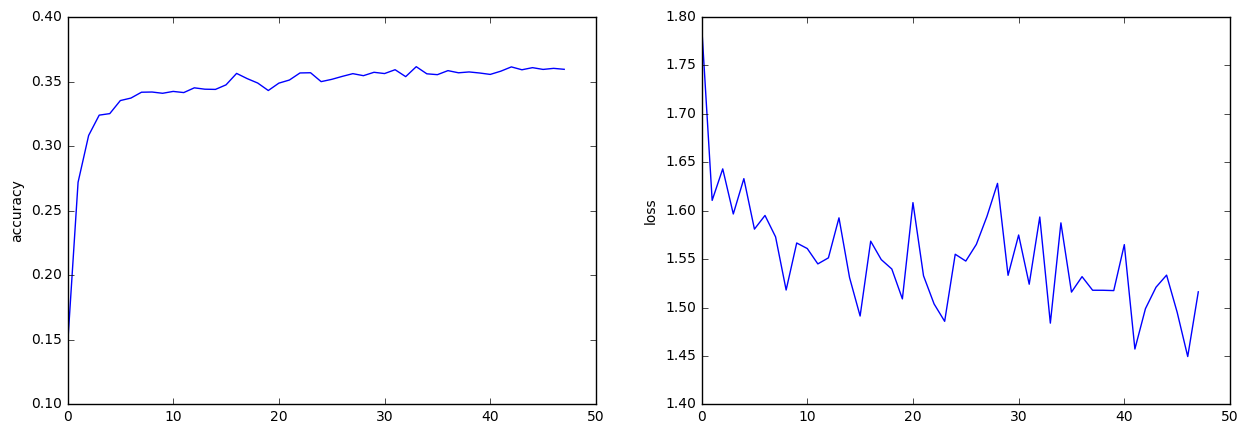

In [15]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.concatenate([[accuracy[0] * 100], accuracy[1:]]))
plt.ylabel("accuracy")
plt.subplot(1, 2, 2)
plt.plot(loss)
plt.ylabel("loss")

### How many extra computations are being done here?

In [16]:
data = iter(PaddedIterator(train, 256))
avg_extra_bits = 0
for _ in range(100):
    _, _, seqlen = next(data)
    avg_extra_bits += np.mean(max(seqlen) - seqlen)
print("The excess comuputations per input is {0:0.2f} extra inputs".format(avg_extra_bits / 100))

The excess comuputations per input is 12.75 extra inputs


### How can we redcue the computations?

We cannot just sort the input and feed it to the RNN, because then our model will be biased and it will assume that first the weights will adapt according to the sort-length inputs and then to the long-length input. We are unneccessary introducing this biasedness in the model. Instead of that, a better idea is to divide the data into different chunks according to their length and then select a chunk randomly and then select a batch from a chunk. 

In [17]:
length_value_counts = train.length.value_counts(sort=False)

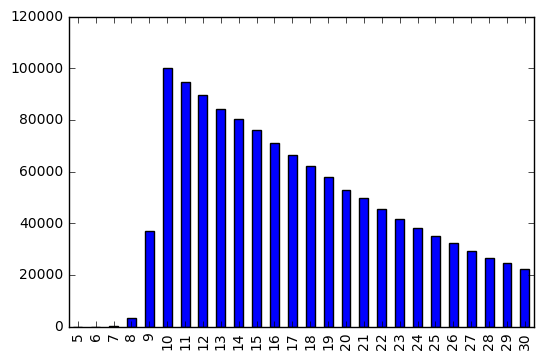

In [18]:
length_value_counts.plot(kind="bar")

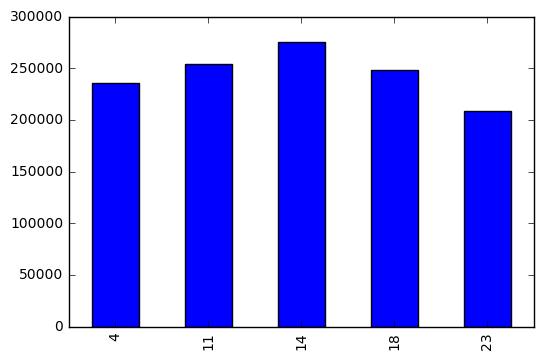

In [19]:
pd.value_counts(train.length, sort=False, bins=[4, 11, 14, 18, 23, 30]).plot(kind="bar")

In [20]:
class PaddedBucketedIterator(object):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size
        self.bucket_boundaries = [4, 11, 14, 18, 23, 30]
        self.dfs = []
        for i in range(len(self.bucket_boundaries) - 1):
            self.dfs.append((self.df[(self.df.length > self.bucket_boundaries[i]) & 
                                    (self.df.length <= self.bucket_boundaries[i + 1])]
                             .reset_index()))
        self.num_buckets = len(self.dfs)
        self.indexes = [0] * self.num_buckets
        
    def __iter__(self):
        while self.dfs: 
            bucket_number = np.random.choice(len(self.dfs))
            df = self.dfs[bucket_number]
            index = self.indexes[bucket_number]
            if index + self.batch_size < len(df):
                yield self.padding(df.ix[index:index + self.batch_size - 1])
                self.indexes[bucket_number] += self.batch_size
            else:
                self.dfs.pop(bucket_number)
            
    def padding(self, batch):
        batch_length = batch["length"]
        max_length = np.max(batch_length)
        inputs = batch["as_numbers"]
        padded_inputs = np.zeros((batch.shape[0], max_length), dtype=int)
        for i, (input_, length)  in enumerate(zip(inputs, batch_length)):
            padded_inputs[i, :length] = input_
        target = batch["gender"] * 3 + batch["age_bracket"]
        
        return padded_inputs, target.values, batch_length.values

### After bucketing, how many extra computations that we are doing?

In [21]:
data = iter(PaddedBucketedIterator(train, 256))
avg_extra_bits = 0
for _ in range(100):
    _, _, seqlen = next(data)
    avg_extra_bits += np.mean(max(seqlen) - seqlen)
print("The excess comuputations per input is {0:0.2f} extra inputs".format(avg_extra_bits / 100))

The excess comuputations per input is 1.71 extra inputs


### Training using a bucketed iterator (It should be faster than the previous iterator.)

In [42]:
graph = build_graph()

In [43]:
tic = time.time()
loss, accuracy = train_graph(graph, DataIterator=PaddedBucketedIterator)
toc = time.time()
print("Time in running one epoch is {0:0.2f}".format((toc - tic) / 60))

The testing accuracy of the model after 0 is 0.3469278685467905
Time in running one epoch is 8.96


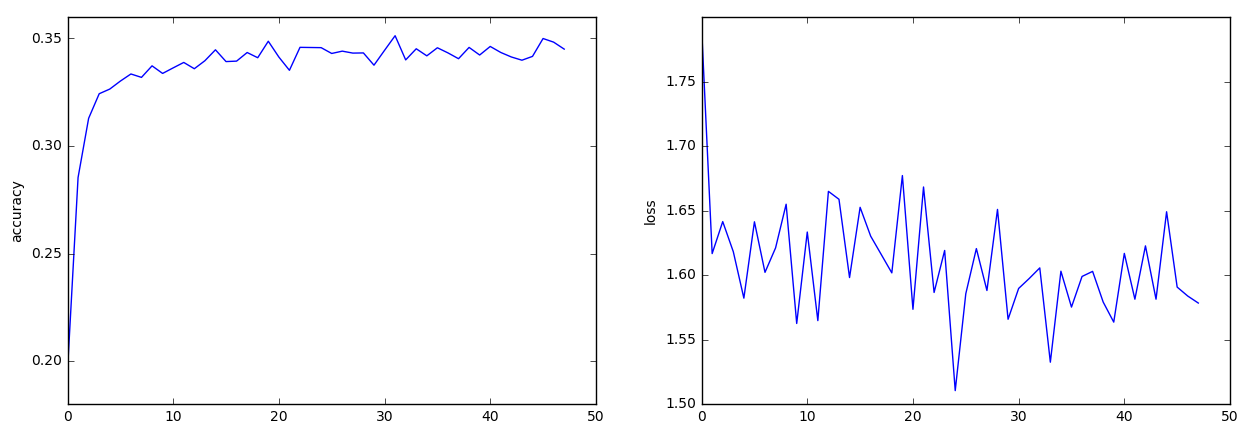

In [44]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.concatenate([[accuracy[0] * 100], accuracy[1:]]))
plt.ylabel("accuracy")
plt.subplot(1, 2, 2)
plt.plot(loss)
plt.ylabel("loss")

** In this demonstration, bucketing increased the training speed by 50 %. **

### How can we use the RNN to make predictions of age and gender at every time slot?

Here I need to take care of few things:
1. To pass a batch from RNN, I need to make all the inputs sequence of same length.
2. To make them same length, I have to pad them with extra `padded bits`.
3. However, these padded bits do not contribute in computing losses.
4. So when we compute loss, we need to make their loss 0. We can use a masker that will make their loss 0. In backpropogation, when we do multiplication, the gradient is multiplied by the opposite term. Hence by multiplying the masker, no gradient will propogate for the padded bits.
5. In this graph, I will also learn the initial state of the LSTM.

In [91]:
def build_graph(
        vocab_size=len(vocab),
        state_size=64,
        batch_size=256,
        num_classes=6,
        learning_rate=0.001):
    
    reset_graph()
    
    #placeholders
    x = tf.placeholder(tf.int32, shape=(batch_size, None), name="x")
    y = tf.placeholder(tf.int32, shape=(batch_size,), name="y")
    seqlen = tf.placeholder(tf.int32, shape=(batch_size,), name="sequence_length")
    
    #Change y
    y_ = tf.tile(tf.expand_dims(y, 1), [1, tf.shape(x)[1]])
    y_ = tf.reshape(y_, (-1,))
    
    #mask for computing the loss
    mask = tf.cast(tf.sequence_mask(seqlen, tf.shape(x)[1]), tf.float32)
    mask = tf.reshape(mask, (-1,))
    
    # word embeddings
    W_embeddings = tf.get_variable("embeddings", shape=(vocab_size, state_size), 
                                   initializer=tf.contrib.layers.xavier_initializer())
    #rnn_inputs
    rnn_inputs = tf.nn.embedding_lookup(W_embeddings, x)
    
    #GRU cell
    gru_cell = tf.nn.rnn_cell.GRUCell(state_size)
    init_state = tf.get_variable("init_state", shape=(1, state_size), 
                                 initializer=tf.constant_initializer(0.0))
    init_state = tf.tile(init_state, [batch_size, 1])
    
    #GRU layer
    outputs, final_states = tf.nn.dynamic_rnn(gru_cell, rnn_inputs, seqlen,
                                   initial_state=init_state)
    outputs = tf.reshape(outputs, [-1, state_size])
    
    # Softmax layer
    W_softmax = tf.get_variable("softmax_w", shape=(state_size, num_classes), 
                                initializer=tf.contrib.layers.xavier_initializer())
    b_softmax = tf.get_variable("softmax_b", shape=(num_classes,), initializer=tf.constant_initializer(0.0))
    
    #logits
    logits = tf.matmul(outputs, W_softmax) + b_softmax
    
    #losses
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_)
    masked_losses = tf.mul(mask, losses)
    total_loss = tf.reduce_sum(masked_losses) / tf.cast(tf.reduce_sum(seqlen), tf.float32)
    
    #metrics
    predictions = tf.nn.softmax(logits)
    correct = tf.equal(tf.cast(tf.argmax(predictions, dimension=1), tf.int32), y_) 
    correct = tf.cast(correct, tf.float32) * mask
    accuracy = tf.reduce_sum(correct) / tf.cast(tf.reduce_sum(seqlen), tf.float32)
    
    #update
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(total_loss)
    return {"x": x,
            "y": y,
            "seqlen": seqlen,
            "loss": total_loss,
            "train_op": train_op,
            "accuracy": accuracy}


In [92]:
g = build_graph()

In [93]:
tic = time.time()
loss, accuracy = train_graph(g, DataIterator=PaddedBucketedIterator)
toc = time.time()
print("the time taken to run one epoch is {0:0.2f}".format((toc - tic) / 60))

The testing accuracy of the model after 0 is 0.32379377424878336
the time taken to run one epoch is 13.08


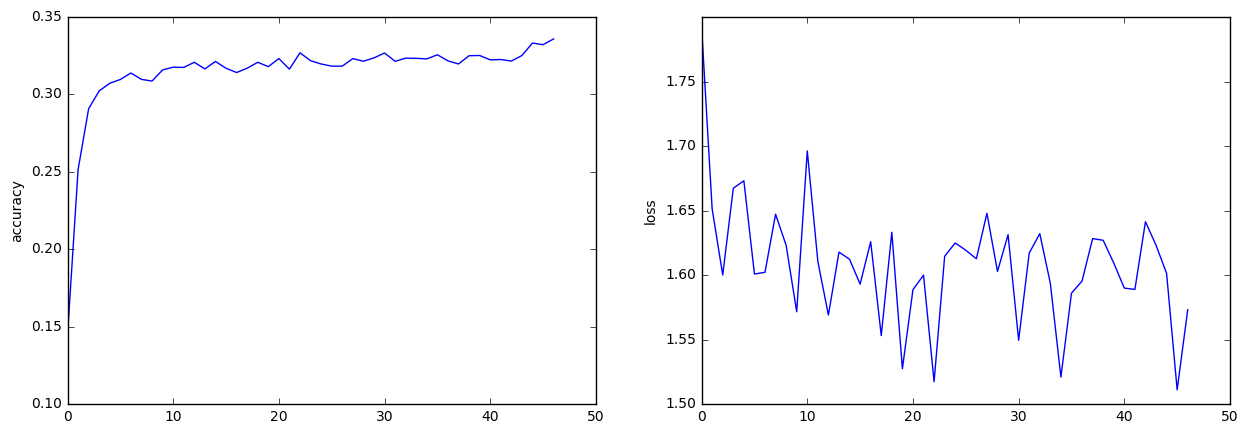

In [94]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.concatenate([[accuracy[0] * 100], accuracy[1:]]))
plt.ylabel("accuracy")
plt.subplot(1, 2, 2)
plt.plot(loss)
plt.ylabel("loss")

We get less accuracy in `sequence 2 sequence` prediction model than in `sequence prediction` because at the initial time-steps there is no information available for the network to predict aga-group.

#### small experimental setups

In [45]:
batch_size = 5 
state_size = 5
vocab_size = 5

In [69]:
sess.close()
tf.reset_default_graph()
x = tf.placeholder(tf.int32, shape=(batch_size, None), name="x")
y = tf.placeholder(tf.int32, shape=(batch_size,), name="y")
seqlen = tf.placeholder(tf.int32, shape=(batch_size,), name="sequence_length")

#Change y
y_ = tf.tile(tf.expand_dims(y, 1), [1, tf.shape(x)[1]])

#mask for computing the loss
mask = tf.sequence_mask(seqlen, tf.shape(x)[1])

# word embeddings
W_embeddings = tf.get_variable("embeddings", shape=(vocab_size, state_size), 
                               initializer=tf.contrib.layers.xavier_initializer())
#rnn_inputs
rnn_inputs = tf.nn.embedding_lookup(W_embeddings, x)

#GRU cell
gru_cell = tf.nn.rnn_cell.GRUCell(state_size)
init_state = tf.get_variable("init_state", shape=(1, state_size), 
                             initializer=tf.constant_initializer(0.0))
init_state = tf.tile(init_state, [batch_size, 1])

#GRU layer
outputs, final_states = tf.nn.dynamic_rnn(gru_cell, rnn_inputs, seqlen,
                               initial_state=init_state)
# softmax
W_softmax = tf.get_variable("softmax_w", shape=(state_size, num_classes), 
                            initializer=tf.contrib.layers.xavier_initializer())
b_softmax = tf.get_variable("softmax_b", shape=(num_classes,), initializer=tf.constant_initializer(0.0))


In [70]:
x_ = [[1, 2, 0], [1, 1, 2], [3, 2, 0], [2, 1, 4], [2, 4, 3]]
y1 = [1, 2, 3, 0, 4]
seqlen_ = [2, 3, 2, 3, 3]

In [71]:
sess = tf.InteractiveSession()

In [75]:
sess.run(tf.initialize_all_variables())
feed_dict = {x: x_, y: y1, seqlen:seqlen_}

In [76]:
sess.run(outputs, feed_dict)

array([[ 0.06025794, -0.03353748,  0.01060029,  0.06055411,  0.05844268],
       [ 0.11058003,  0.05836005, -0.11269359,  0.10925433,  0.06435023],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.06025794, -0.03353748,  0.01060029,  0.06055411,  0.05844268],
       [ 0.10036166, -0.05334779,  0.0102554 ,  0.10533797,  0.09886517],
       [ 0.13588829,  0.05123869, -0.11799487,  0.13865218,  0.09238912],
       [-0.06522267,  0.10463995, -0.21779805, -0.06073106,  0.0482189 ],
       [ 0.05833961,  0.13954523, -0.24763361,  0.00957109,  0.0558544 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.07376681,  0.07268513, -0.11097097,  0.06933933,  0.02259026],
       [ 0.11855976,  0.02634065, -0.07345184,  0.10759062,  0.06398816],
       [-0.00089759, -0.00189805, -0.07124263, -0.04999942,  0.07410802],
       [ 0.07376681,  0.07268513, -0.11097097,  0.06933933,  0.02259027],
       [-0.0350235 ,  0.02852054, -0.0

In [77]:
outputs = tf.reshape(outputs, [-1, state_size])
sess.run(outputs, feed_dict)

array([[ 0.06025794, -0.03353748,  0.01060029,  0.06055411,  0.05844268],
       [ 0.11058003,  0.05836005, -0.11269359,  0.10925433,  0.06435023],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.06025794, -0.03353748,  0.01060029,  0.06055411,  0.05844268],
       [ 0.10036166, -0.05334779,  0.0102554 ,  0.10533797,  0.09886517],
       [ 0.13588829,  0.05123869, -0.11799487,  0.13865218,  0.09238912],
       [-0.06522267,  0.10463995, -0.21779805, -0.06073106,  0.0482189 ],
       [ 0.05833961,  0.13954523, -0.24763361,  0.00957109,  0.0558544 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.07376681,  0.07268513, -0.11097097,  0.06933933,  0.02259026],
       [ 0.11855976,  0.02634065, -0.07345184,  0.10759062,  0.06398816],
       [-0.00089759, -0.00189805, -0.07124263, -0.04999942,  0.07410802],
       [ 0.07376681,  0.07268513, -0.11097097,  0.06933933,  0.02259027],
       [-0.0350235 ,  0.02852054, -0.0

In [78]:
# Softmax layer
num_classes = 6

In [79]:
logits = tf.matmul(outputs, W_softmax) + b_softmax

In [80]:
sess.run(y_, feed_dict)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [0, 0, 0],
       [4, 4, 4]], dtype=int32)

In [81]:
y1_ = tf.reshape(y_, (-1,))

In [82]:
sess.run(y1_, feed_dict)

array([1, 1, 1, 2, 2, 2, 3, 3, 3, 0, 0, 0, 4, 4, 4], dtype=int32)

In [83]:
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y1_)

In [85]:
masked_array = tf.sequence_mask(seqlen, tf.shape(x)[1])

In [86]:
masked_array = tf.cast(tf.reshape(masked_array, (-1, )), dtype=tf.float32)

In [87]:
sess.run(masked_array, feed_dict)

array([ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.], dtype=float32)

In [ ]:
masked_loss = masked_array * loss

In [ ]:
total_loss = tf.reduce_sum(masked_loss) / tf.cast(tf.reduce_sum(seqlen), tf.float32)

In [ ]:
sess.run(total_loss, feed_dict)

In [ ]:
predictions = tf.cast(tf.argmax(tf.nn.softmax(logits), dimension=1), dtype=tf.int32)

In [ ]:
correct = tf.cast(tf.equal(predictions, y1_), tf.float32)

In [ ]:
masked_correct = correct * masked_array

In [ ]:
total_correct = tf.reduce_sum(masked_correct) / tf.cast(tf.reduce_sum(seqlen), tf.float32)

In [ ]:
sess.run(total_correct, feed_dict)